# TimeGAN

https://www.sciencedirect.com/science/article/pii/S2666285X22000565 (this is the most important one, it all boil down to data cleaning and how clean is it clean)

https://github.com/flaviagiammarino/time-gan-

https://github.com/jsyoon0823/TimeGAN

https://github.com/benearnthof/TimeGAN


In [ ]:
# STEP 1: Install dependencies
!pip install tensorflow pandas scikit-learn matplotlib seaborn --quiet

In [ ]:
# STEP 2: Imports
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving raw_merged_unfiltered.csv to raw_merged_unfiltered.csv


In [ ]:
# STEP 3: Load and preprocess data
#  Load raw dataset
df_raw = pd.read_csv("/content/raw_merged_unfiltered.csv", parse_dates=["Date"])

# === Preprocessing Function ===
def preprocess_timegan_data(filepath, start_date="2017-01-01", end_date="2024-12-31", n_neighbors=3, seq_len=72):
    # STEP 1: Load raw data
    df = pd.read_csv(filepath, parse_dates=["Date"])

    # STEP 2: Optional filtering by 'series_type'
    if "series_type" in df.columns:
        df = df[df["series_type"] == "change_weekly"]

    # STEP 3: Clean numeric columns
    for col in df.columns:
        if col != "Date":
            df[col] = pd.to_numeric(df[col].astype(str).str.replace(r"[^\d\.\-]", "", regex=True), errors="coerce")

    # STEP 4: Resample to monthly (MS = Month Start)
    df = df.set_index("Date").resample("MS").mean()

    # STEP 5: Slice date range
    df = df.loc[start_date:end_date]

    # STEP 6: Explicit whitelist of required features
    required_features = [
        'ron95', 'ron97', 'diesel', 'diesel_eastmsia',
        'AirFreightRate_Weekly', 'AirFreightRate_Annual',
        'AsiaPacific', 'AsiaPacific_rescaled',
        'jet_fuel', 'oilprice', 'TradeVolume'
    ]
    existing_features = [col for col in required_features if col in df.columns]
    df = df[existing_features]

    # STEP 7: Drop constant columns (zero std)
    df = df.loc[:, df.std() > 0]

    # STEP 8: Save feature names
    feature_names = df.columns.tolist()

    # STEP 9: KNN Imputation
    imputer = KNNImputer(n_neighbors=n_neighbors)
    df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=feature_names, index=df.index)

    # STEP 10: Scaling
    scaler = MinMaxScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df_imputed), columns=feature_names, index=df.index)
    print(df_scaled.shape)

    # STEP 11: Sequence generation
    def create_sequences(data, seq_len=72):
        return np.array([data[i:i+seq_len] for i in range(len(data) - seq_len)])

    # Use .values to extract the raw NumPy array
    data_seq = create_sequences(df_scaled.values, seq_len=72)
    print("✅ Final shape of data_seq:", data_seq.shape)

    return data_seq, df_scaled, df_imputed, scaler, feature_names

# === Call Preprocessing ===
data_seq, df_scaled, df_imputed, scaler, feature_names = preprocess_timegan_data(
    filepath="/content/raw_merged_unfiltered.csv"
)

# === Save Outputs ===
df_scaled.to_csv("/content/final_cleaned_scaled_2017_2024.csv")
df_imputed.to_csv("/content/final_cleaned_unscaled_2017_2024.csv")

# === Optional Preview ===
print("✅ Preprocessing complete.")
print("📅 Shape:", df_scaled.shape)
print("📈 Features:", feature_names)

(93, 6)
✅ Final shape of data_seq: (21, 72, 6)
✅ Preprocessing complete.
📅 Shape: (93, 6)
📈 Features: ['ron95', 'ron97', 'diesel', 'diesel_eastmsia', 'AsiaPacific', 'AsiaPacific_rescaled']


In [ ]:
# STEP 6: TimeGAN component definitions
class Embedder(tf.keras.Model):
    def __init__(self, hidden_dim):
        super().__init__()
        self.model = tf.keras.Sequential([
            layers.GRU(hidden_dim, return_sequences=True),
            layers.LayerNormalization(),
            layers.GRU(hidden_dim, return_sequences=True),
            layers.Dense(hidden_dim, activation='sigmoid')
        ])
    def call(self, x): return self.model(x)

class Recovery(tf.keras.Model):
    def __init__(self, hidden_dim, output_dim):
        super().__init__()
        self.model = tf.keras.Sequential([
            layers.GRU(hidden_dim, return_sequences=True),
            layers.LayerNormalization(),
            layers.GRU(hidden_dim, return_sequences=True),
            layers.Dense(output_dim)
        ])
    def call(self, h): return self.model(h)

class Generator(tf.keras.Model):
    def __init__(self, hidden_dim):
        super().__init__()
        self.model = tf.keras.Sequential([
            layers.GRU(hidden_dim, return_sequences=True),
            layers.LayerNormalization(),
            layers.GRU(hidden_dim, return_sequences=True),
            layers.Dense(hidden_dim)
        ])
    def call(self, z): return self.model(z)

class Supervisor(tf.keras.Model):
    def __init__(self, hidden_dim):
        super().__init__()
        self.model = tf.keras.Sequential([
            layers.GRU(hidden_dim, return_sequences=True),
            layers.LayerNormalization(),
            layers.GRU(hidden_dim, return_sequences=True),
            layers.Dense(hidden_dim)
        ])
    def call(self, h): return self.model(h)

class Discriminator(tf.keras.Model):
    def __init__(self, hidden_dim):
        super().__init__()
        self.model = tf.keras.Sequential([
            layers.GRU(hidden_dim, return_sequences=True),
            layers.LayerNormalization(),
            layers.GRU(hidden_dim, return_sequences=True),
            layers.Dense(1)
        ])
    def call(self, x): return self.model(x)

In [ ]:
# STEP 7: Training Setup
hidden_dim = 24
batch_size = 8
epochs = 500
data_dim = data_seq.shape[2]
feature_weights = tf.constant([1.0] * data_dim, dtype=tf.float32)
recon_weight = 5.0

embedder = Embedder(hidden_dim)
recovery = Recovery(hidden_dim, data_dim)
generator = Generator(hidden_dim)
supervisor = Supervisor(hidden_dim)
discriminator = Discriminator(hidden_dim)

e_optimizer = tf.keras.optimizers.Adam(0.0003)
g_optimizer = tf.keras.optimizers.Adam(0.0003)
d_optimizer = tf.keras.optimizers.Adam(0.0003)

def sample_Z(n, seq_len, z_dim):
    return np.random.uniform(0, 1, size=(n, seq_len, z_dim))

In [ ]:
# Training functions
@tf.function
def train_embedder(X):
    with tf.GradientTape() as tape:
        H = embedder(X)
        X_tilde = recovery(H)
        loss = tf.reduce_mean(tf.tensordot(tf.square(X - X_tilde), feature_weights, axes=[[2],[0]]))
    grads = tape.gradient(loss, embedder.trainable_variables + recovery.trainable_variables)
    e_optimizer.apply_gradients(zip(grads, embedder.trainable_variables + recovery.trainable_variables))
    return loss

@tf.function
def train_generator(Z, X_real):
    with tf.GradientTape() as tape:
        H = generator(Z)
        H_hat = supervisor(H)
        Y_fake = discriminator(H_hat)

        g_loss_adv = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
            labels=tf.ones_like(Y_fake), logits=Y_fake))

        temporal_loss = tf.reduce_mean(tf.square(H_hat[:, 1:, :] - H_hat[:, :-1, :]))

        X_hat = recovery(H_hat)
        recon_loss = tf.reduce_mean(tf.tensordot(tf.square(X_real - X_hat), feature_weights, axes=[[2], [0]]))

        total_loss = g_loss_adv + temporal_loss + recon_weight * recon_loss

    grads = tape.gradient(total_loss, generator.trainable_variables + supervisor.trainable_variables)
    g_optimizer.apply_gradients(zip(grads, generator.trainable_variables + supervisor.trainable_variables))

    return total_loss  # ✅ Ensure the loss is returned


@tf.function
def train_discriminator(X, Z):
    with tf.GradientTape() as tape:
        H = embedder(X)
        H_hat = supervisor(generator(Z))
        Y_real = discriminator(H)
        Y_fake = discriminator(H_hat)
        loss_real = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(Y_real), logits=Y_real)
        loss_fake = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(Y_fake), logits=Y_fake)
        loss = tf.reduce_mean(loss_real + loss_fake)
    grads = tape.gradient(loss, discriminator.trainable_variables)
    d_optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))
    return loss

In [ ]:
# Training loop
X = tf.convert_to_tensor(data_seq.astype(np.float32))
for epoch in range(epochs):
    idx = np.random.permutation(len(X))
    losses = {"embedder": [], "generator": [], "discriminator": []}

    for i in range(0, len(X) - batch_size, batch_size):
        batch = tf.gather(X, idx[i:i+batch_size])
        Z = tf.convert_to_tensor(sample_Z(batch_size, batch.shape[1], hidden_dim), dtype=tf.float32)

        e_loss = train_embedder(batch)
        g_loss = train_generator(Z, batch)
        d_loss = train_discriminator(batch, Z)

        losses["embedder"].append(e_loss.numpy())
        losses["generator"].append(g_loss.numpy())
        losses["discriminator"].append(d_loss.numpy())

    if epoch % 50 == 0 or epoch == epochs - 1:
        print(f"[Epoch {epoch:>3}] "
              f"Embedder Loss: {np.mean(losses['embedder']):.4f} | "
              f"Generator Loss: {np.mean(losses['generator']):.4f} | "
              f"Discriminator Loss: {np.mean(losses['discriminator']):.4f}")


[Epoch   0] Embedder Loss: 0.0529 | Generator Loss: 45.2062 | Discriminator Loss: 0.0212
[Epoch  50] Embedder Loss: 0.0479 | Generator Loss: 4.3018 | Discriminator Loss: 0.0436
[Epoch 100] Embedder Loss: 0.0495 | Generator Loss: 7.0582 | Discriminator Loss: 0.0415
[Epoch 150] Embedder Loss: 0.0431 | Generator Loss: 1.8226 | Discriminator Loss: 0.3840
[Epoch 200] Embedder Loss: 0.0405 | Generator Loss: 2.6310 | Discriminator Loss: 0.2076
[Epoch 250] Embedder Loss: 0.0310 | Generator Loss: 1.9928 | Discriminator Loss: 0.3957
[Epoch 300] Embedder Loss: 0.0285 | Generator Loss: 2.0787 | Discriminator Loss: 0.5711
[Epoch 350] Embedder Loss: 0.0226 | Generator Loss: 2.2797 | Discriminator Loss: 0.3591
[Epoch 400] Embedder Loss: 0.0178 | Generator Loss: 2.7733 | Discriminator Loss: 0.2332
[Epoch 450] Embedder Loss: 0.0127 | Generator Loss: 4.7839 | Discriminator Loss: 0.4340
[Epoch 499] Embedder Loss: 0.0106 | Generator Loss: 3.8648 | Discriminator Loss: 0.1817


📊 Comparison Table (Actual vs Synthetic):


,Date,ron95,ron97,diesel,diesel_eastmsia,AsiaPacific,AsiaPacific_rescaled,ron95_synth,ron97_synth,diesel_synth,diesel_eastmsia_synth,AsiaPacific_synth,AsiaPacific_rescaled_synth
0,2019-01-01,-0.044,-0.0440,-1.734723e-17,-1.734723e-17,100.707965,100.707965,-0.084215,-0.079002,0.006451,-0.044164,97.484909,97.341660
1,2019-02-01,0.025,0.0250,0.000000e+00,0.000000e+00,100.707965,100.707965,-0.039820,-0.048522,0.030784,-0.029917,98.394363,97.667664
2,2019-03-01,0.000,0.0500,0.000000e+00,0.000000e+00,100.707965,100.707965,-0.019839,-0.057961,0.025287,-0.024097,99.182220,98.054497
3,2019-04-01,0.000,0.0450,0.000000e+00,0.000000e+00,100.707965,100.707965,-0.016965,-0.073783,0.020012,-0.016201,99.568161,98.955513
4,2019-05-01,0.000,-0.0125,0.000000e+00,0.000000e+00,100.707965,100.707965,-0.019544,-0.079176,0.019233,-0.010832,99.966087,100.137039
5,2019-06-01,0.000,-0.0675,0.000000e+00,0.000000e+00,100.707965,100.707965,-0.017748,-0.072901,0.020374,-0.007542,100.429192,100.950859
6,2019-07-01,0.000,0.0175,0.000000e+00,0.000000e+00,100.707965,100.707965,-0.012922,-0.066539,0.016098,-0.007410,100.663559,101.124802
7,2019-08-01,0.000,-0.0120,0.000000e+00,0.000000e+00,100.707965,100.707965,-0.007106,-0.058454,0.011373,-0.007051,100.952446,101.138557
8,2019-09-01,0.000,0.0725,0.000000e+00,0.000000e+00,100.707965,100.707965,-0.005431,-0.052887,0.007964,-0.010736,101.190773,101.252655
9,2019-10-01,0.000,-0.0500,0.000000e+00,0.000000e+00,100.707965,100.707965,-0.008864,-0.058741,0.004517,-0.019472,101.390717,101.154427


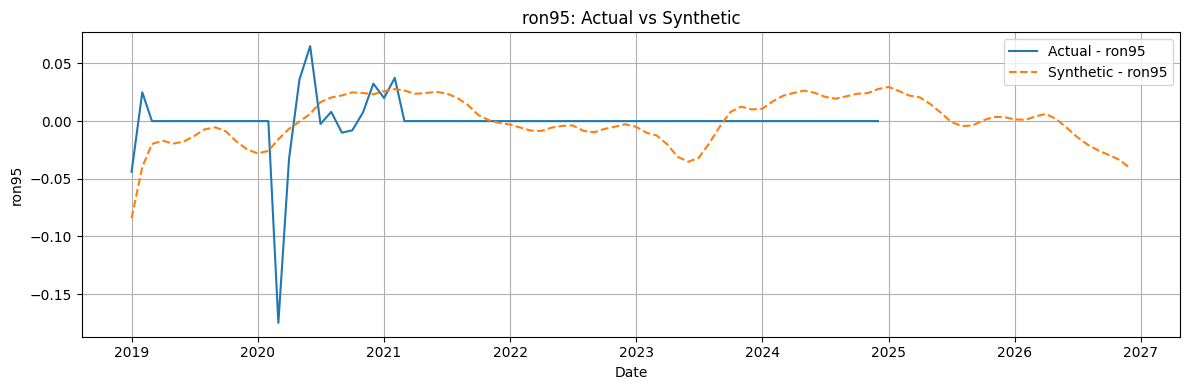

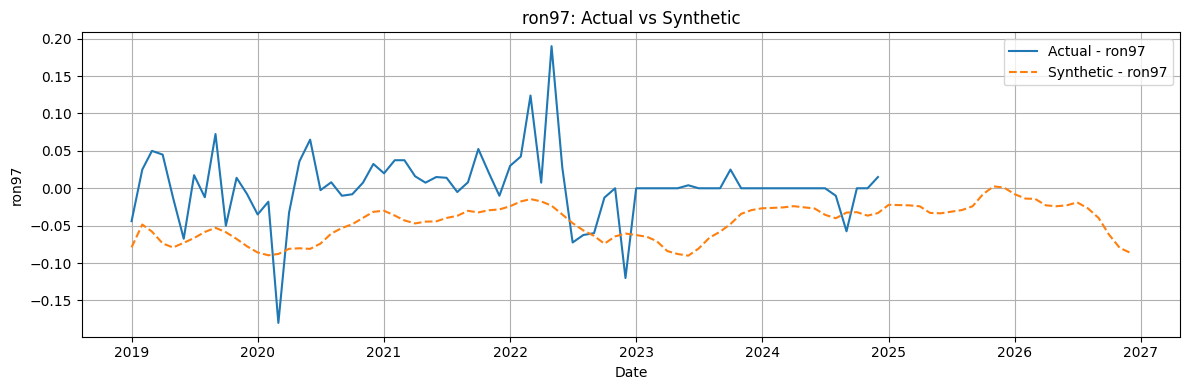

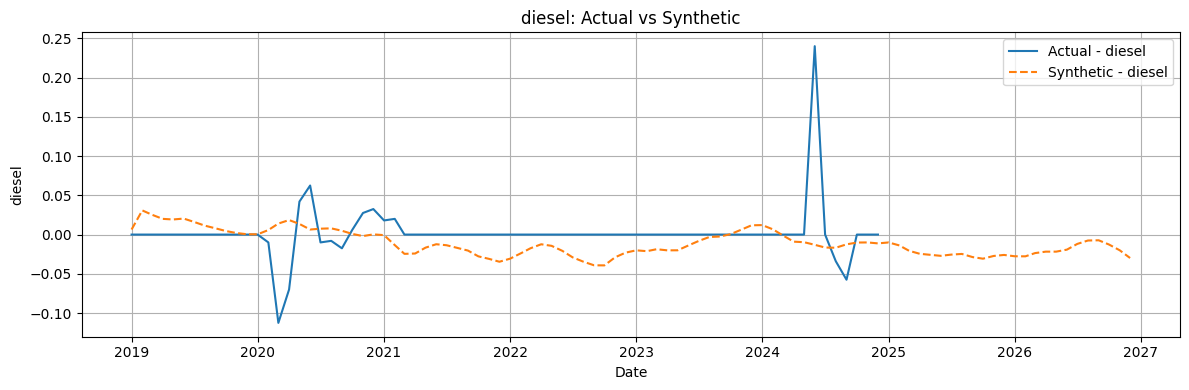

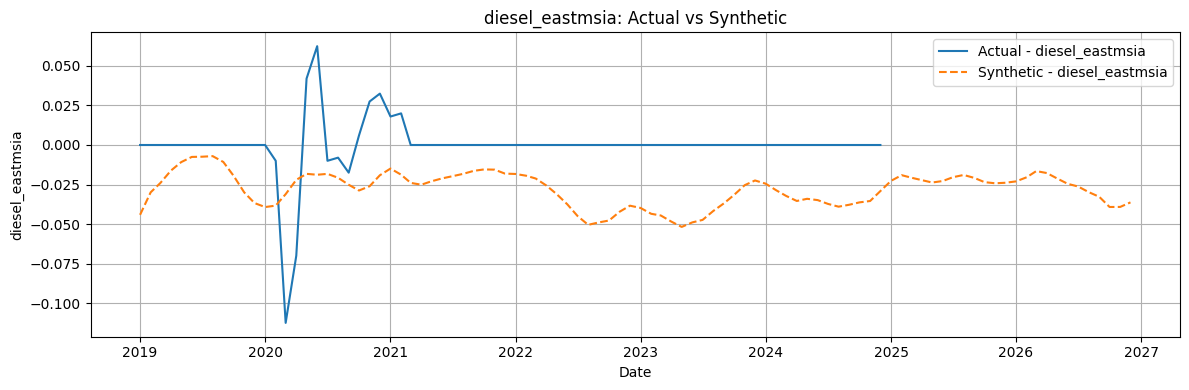

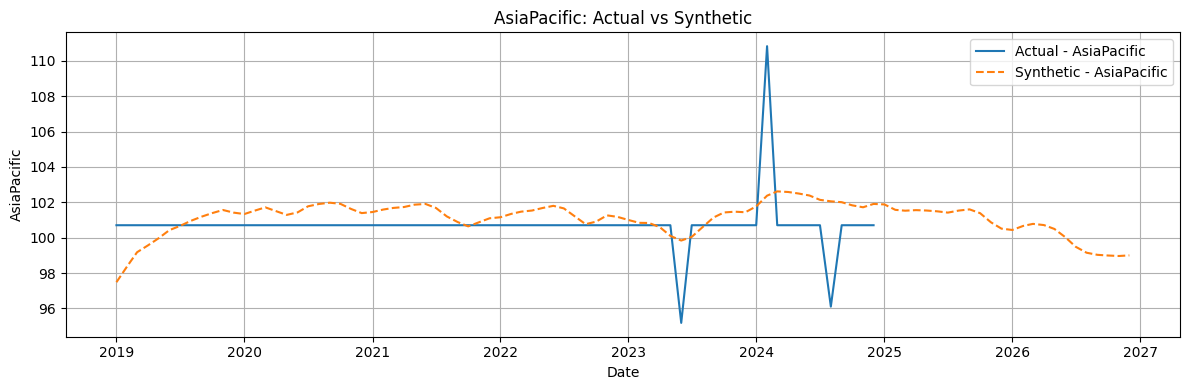

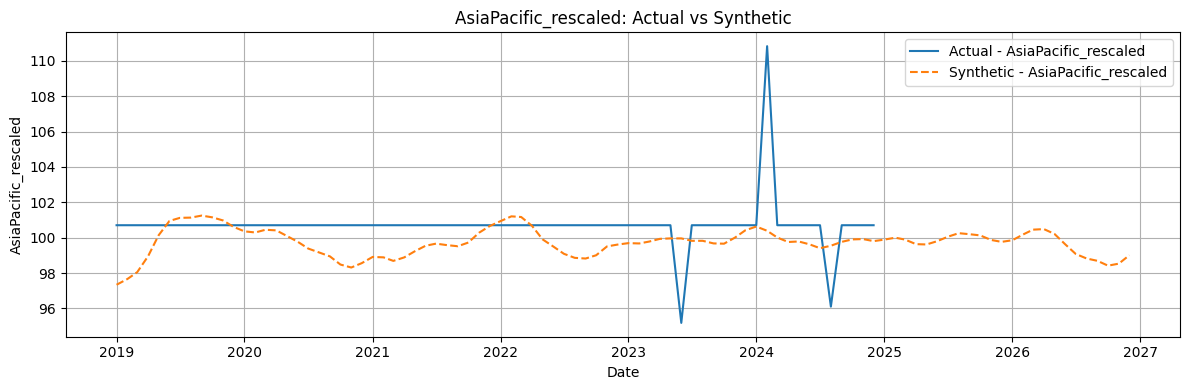

📉 RMSE and MAE per feature:
ron95                | RMSE: 0.0285 | MAE: 0.0198
ron97                | RMSE: 0.0691 | MAE: 0.0595
diesel               | RMSE: 0.0408 | MAE: 0.0241
diesel_eastmsia      | RMSE: 0.0359 | MAE: 0.0324
AsiaPacific          | RMSE: 1.6631 | MAE: 1.0713
AsiaPacific_rescaled | RMSE: 1.8865 | MAE: 1.2768


,Feature,RMSE,MAE
0,ron95,0.028537,0.019827
1,ron97,0.069137,0.059454
2,diesel,0.040839,0.024141
3,diesel_eastmsia,0.035889,0.032395
4,AsiaPacific,1.663100,1.071349
5,AsiaPacific_rescaled,1.886454,1.276796


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import seaborn as sns

# === STEP 1: Generate synthetic data ===
Z_synth = tf.random.normal(shape=(60, seq_len, hidden_dim))
H_synth = supervisor(generator(Z_synth))
X_synth = recovery(H_synth).numpy()
X_synth_avg = np.mean(X_synth, axis=0)  # shape: (seq_len, num_features)
X_synth_rescaled = scaler.inverse_transform(X_synth_avg)

# Define the original feature names (same order as your input features)
original_feature_names = ['ron95', 'ron97', 'diesel', 'diesel_eastmsia', 'AsiaPacific', 'AsiaPacific_rescaled']

# === STEP 1.5: Ensure column names exist ===
original_feature_names = df_imputed.columns.tolist()
if "Date" in original_feature_names:
    original_feature_names.remove("Date")

# === STEP 2: Create date range and synthetic dataframe ===
date_range = pd.date_range(start="2019-01-01", periods=seq_len, freq="MS")
df_synth = pd.DataFrame(X_synth_rescaled, columns=original_feature_names)
df_synth["Date"] = date_range
df_synth = df_synth[["Date"] + original_feature_names]

# === STEP 3: Slice the real data for the same period ===
df_real = df_imputed.loc["2019-01-01": "2024-12-01"].copy().reset_index()
df_real = df_real[["Date"] + original_feature_names]

# === STEP 4: Display both side-by-side ===
df_compare = df_real.copy()
for col in original_feature_names:
    df_compare[f"{col}_synth"] = df_synth[col]

from IPython.display import display
print("📊 Comparison Table (Actual vs Synthetic):")
display(df_compare.head(10))  # show top 10 rows

# === STEP 5: Plot each feature ===
for col in original_feature_names:
    plt.figure(figsize=(12, 4))
    plt.plot(df_real["Date"], df_real[col], label=f"Actual - {col}")
    plt.plot(df_synth["Date"], df_synth[col], label=f"Synthetic - {col}", linestyle="--")
    plt.title(f"{col}: Actual vs Synthetic")
    plt.xlabel("Date")
    plt.ylabel(col)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# === STEP 6: RMSE and MAE per feature ===
df_synth = df_synth.iloc[:len(df_real)]
print("📉 RMSE and MAE per feature:")
metrics = []
for col in original_feature_names:
    rmse = np.sqrt(mean_squared_error(df_real[col], df_synth[col]))
    mae = mean_absolute_error(df_real[col], df_synth[col])
    metrics.append({"Feature": col, "RMSE": rmse, "MAE": mae})
    print(f"{col:<20} | RMSE: {rmse:.4f} | MAE: {mae:.4f}")

# Optional: display metrics in table
df_metrics = pd.DataFrame(metrics)
display(df_metrics)


✅ Saved to /content/timegan_synthetic_monthly_data_v4.csv


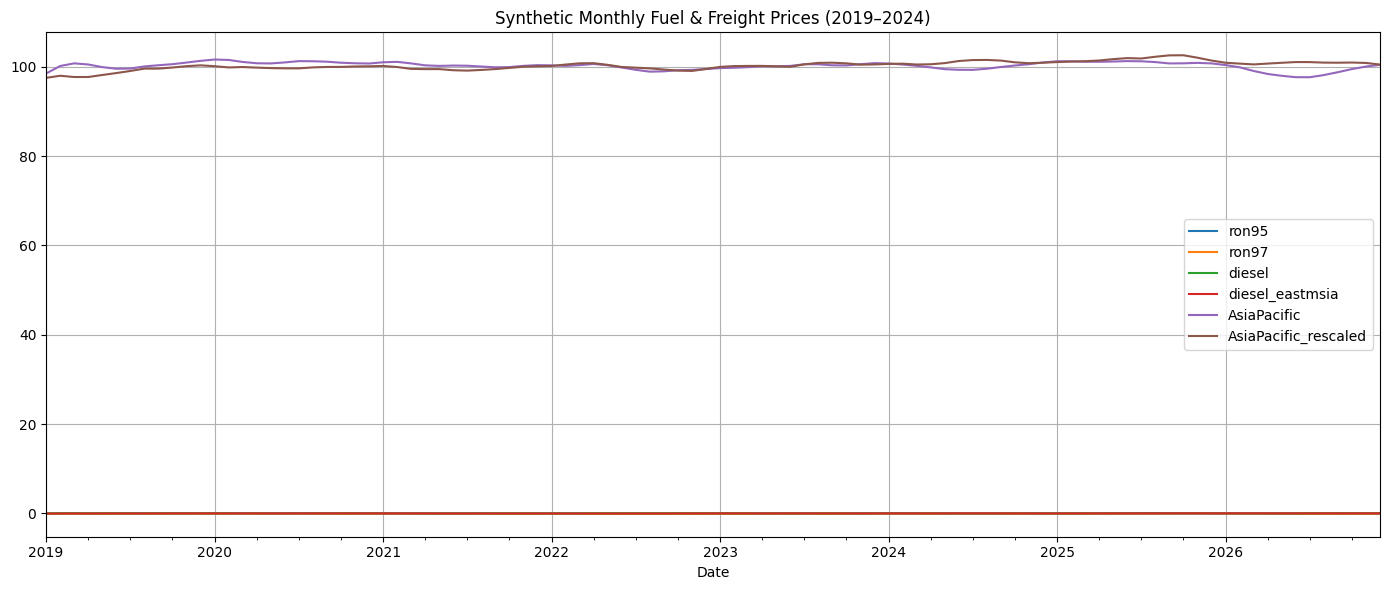

In [ ]:
# STEP 8: Generate synthetic data
Z_synth = tf.random.normal(shape=(60, seq_len, hidden_dim))
H_synth = supervisor(generator(Z_synth))
X_synth = recovery(H_synth).numpy()
X_synth_avg = np.mean(X_synth, axis=0)
X_synth_rescaled = scaler.inverse_transform(X_synth_avg)

# Save synthetic data
date_range = pd.date_range(start="2019-01-01", periods=seq_len, freq="MS")
df_synth = pd.DataFrame(X_synth_rescaled, columns=original_feature_names)
df_synth["Date"] = date_range
df_synth = df_synth[["Date"] + original_feature_names]
df_synth.to_csv("/content/timegan_synthetic_monthly_data_v4.csv", index=False)
print("✅ Saved to /content/timegan_synthetic_monthly_data_v4.csv")

# Plot
df_synth.set_index("Date").plot(title="Synthetic Monthly Fuel & Freight Prices (2019–2024)", figsize=(14, 6))
plt.grid(True)
plt.tight_layout()
plt.show()